# IMPORTS

In [291]:
import yaml
import firebase_admin
import numpy as np
import re

import time
import pandas as pd 

from selenium import webdriver 
from selenium.webdriver.support.ui import Select
from selenium import webdriver


import matplotlib.pyplot as plt
import logging, joblib, tqdm, itertools, operator, random, collections

import cv2
import skimage
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from cv2 import imread
from cv2 import imwrite
import scipy
from skimage.morphology import opening, disk, closing
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import imageio

from sklearn.cluster import KMeans

from PIL import Image, ImageDraw, ImageFont

from functools import reduce

from collections import namedtuple


import gspread
import httplib2
import os, io
import argparse
import auth


from firebase_admin import credentials
from firebase_admin import firestore


from httplib2 import Http
from oauth2client import file,client, tools
from googleapiclient import discovery
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from oauth2client.service_account import ServiceAccountCredentials



from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# CONNECT TO FIREBASE

In [2]:
filename='/Users/5danalfaro/OAN/credentials/firebase_parameters.json'

In [3]:
# Use a service account
cred = credentials.Certificate(filename)
firebase_admin.initialize_app(cred)

db = firestore.client()

## TEST

In [25]:
col_query = db.collection('mapa_temp')

In [26]:
villages = col_query.stream()

In [27]:
all_villages=[]
for vil in villages:
    all_villages.append(vil.to_dict())
    #print(u'{} => {}'.format(pump.id, pump.to_dict()))

In [28]:
df_villages=pd.DataFrame(all_villages)

In [33]:
df_villages[['latitude','longitude']]=df_villages.apply(lambda x:
                                                       pd.Series([x['coordinates']['longitude'],
                                                                 x['coordinates']['latitude']]),axis=1)

In [35]:
df_villages_fil = df_villages[['arrondissement','name','longitude','latitude','population','fpm']]

# GET MAP AND SCREENSHOT

In [76]:
def crop(image_path, coords, saved_location):
    """
    @param image_path: The path to the image to edit
    @param coords: A tuple of x/y coordinates (x1, y1, x2, y2)
    @param saved_location: Path to save the cropped image
    """
    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image.save(saved_location)

In [40]:
df_villages_to_view=df_villages_fil[(df_villages_fil['fpm']==0) &
                                    (df_villages_fil['latitude'].notnull())]

In [41]:
df_villages_to_view

,arrondissement,name,longitude,latitude,population,fpm
12,GNONKOUROKALI,Sèriasson,10.073972,2.916000,600.0,0
18,TASSO,Kpiré 1,9.734889,3.144556,50.0,0
34,NIKKI,Gah Maro Peuhl,9.935556,3.205750,1440.0,0
43,TASSO,Kala 2,9.735444,3.240444,200.0,0
54,OUENOU,Tata Gando Sansi,9.944778,3.414500,300.0,0
68,BIRO,Tèbo Gando,9.848208,2.843403,474.0,0
84,NIKKI,Angankirou 1,9.796639,3.303056,283.0,0
88,GNONKOUROKALI,Sombirou,9.959139,2.956167,200.0,0
94,GNONKOUROKALI,Guèma Peuhl (Gassa\nWorou),9.966389,2.977389,500.0,0
102,BIRO,Bannon,9.924250,2.786764,400.0,0


In [357]:
# select village
village = df_villages_to_view[df_villages_to_view['name']=='Gah Maro Peuhl']

In [358]:
size=800
lat=village['latitude'].values[0]
long=village['longitude'].values[0]
name=str(village.name.values[0].lower())

In [359]:
#driver = webdriver.Chrome(
#    executable_path=r'/Users/5danalfaro/OAN/nikki_map_house_count/maps_scrapping/chromedriver')

In [360]:
url=('''https://www.google.com/maps/@'''+
     str(long)+','+str(lat)+''','''+str(size)+'''m/data=!3m1!1e3'''
     )

In [364]:
driver.get(url)

In [365]:
#get rid of labels
driver.find_elements_by_class_name("maps-sprite-common-chevron-left")[0].click()
driver.implicitly_wait(1000)
driver.find_elements_by_class_name("searchbox-hamburger")[0].click()
driver.implicitly_wait(1000)
driver.find_elements_by_class_name("widget-settings-sub-button-label")[0].click()

In [366]:

#get rid of sidebar
driver.find_elements_by_class_name('widget-pane-toggle-button')[0].click()

In [367]:
#get rid of privacy reminder
driver.find_elements_by_class_name('widget-consent-button-later')[0].click()

In [345]:
#MANUAL SCROLLING TO GET VILLAGE
#lat_screen=2.9468516
#long_screen=9.9597622
#size_screen=800
lat_screen=2.9157369
long_screen=10.0724401
size_screen=800

In [346]:
url=('''https://www.google.com/maps/@'''+
     str(long_screen)+','+str(lat_screen)+''','''+str(size_screen)+'''m/data=!3m1!1e3'''
     )
driver.get(url)

In [368]:
driver.save_screenshot(name+'.png')

True

In [369]:
a=crop(name+'.png',(40, 100, 1200, 800),name+'_cropped.png')

# COUNT HOUSES

In [310]:

Point = namedtuple('Point', 'x y')

def points_adjoin(p1, p2):
    # to accept diagonal adjacency, use this form
    #return -1 <= p1.x-p2.x <= 1 and -1 <= p1.y-p2.y <= 1
    return (-1 <= p1.x-p2.x <= 1 and p1.y == p2.y or
             p1.x == p2.x and -1 <= p1.y-p2.y <= 1)

def adjoins(pts, pt):
    return any(points_adjoin(p,pt) for p in pts)

def locate_regions(datastring):
    data = datastring
    regions = []
    datapts = [Point(x,y) 
                for y in range(len(data[0]))
                    for x in range(len(data)) if data[x][y]==1]
    for dp in datapts:
        # find all adjoining regions
        adjregs = [r for r in regions if adjoins(r,dp)]
        if adjregs:
            adjregs[0].add(dp)
            if len(adjregs) > 1:
                # joining more than one reg, merge
                regions[:] = [r for r in regions if r not in adjregs]
                regions.append(reduce(set.union, adjregs))
        else:
            # not adjoining any, start a new region
            regions.append(set([dp]))
    return regions

def region_index(regs, p):
    return next((i for i,reg in enumerate(regs) if p in reg), -1)

def print_regions(regs):
    maxx = max(p.x for r in regs for p in r)
    maxy = max(p.y for r in regs for p in r)
    allregionpts = reduce(set.union, regs)
    line = np.ones((maxx+4,maxy+3)) #  empty regular list
    
    for y in range(-1,maxy+2):
        
        for x in range(-1,maxx+2):
            p = Point(x, y)
            if p in allregionpts:
                line[x][y]=1
            else:
                line[x][y]=0


    return line
# test against data set

def get_coord(m_x,m_y,center,im):
     #Lat = Y Long = X
    
    #got manually
    range_x_long=abs(9.96243-9.95707)
    range_y_lat=abs(2.94223 - 2.95123)
    
    
    y_size=len(im[0])
    x_size=len(im)
    
    
    lat_y=center[0] + range_x_long/2 - m_y*range_x_long/x_size
    long_x=center[1] - range_y_lat/2 + m_x*range_y_lat/y_size
    
    return (lat_y,long_x)

In [276]:
def read_image(image):
    kk = imread(image,-1)
    #plt.figure()
    #plt.imshow(kk)
    return kk
def read_image_gray(image):
    bgr_img = imread(image,0) #cv2.IMREAD_GRAYSCALE
    #plt.figure()
    #plt.imshow(bgr_img)
    return bgr_img
def segmentation_by_color(image,th):
    ret,im_thresh= cv2.threshold(image,th,255,cv2.THRESH_BINARY_INV)
    #print (init)
    '''
    alpha Higher values make snake contract faster
    beta Highervalue make snake smoother
    Gamma Timestepping parameter
    '''
    #plt.figure()
    #plt.imshow(im_thresh)
    return im_thresh
#smooth and threshold as image has compression artifacts (jpg)
def gaus_filter(image,sigma):
    im = ndimage.gaussian_filter(image/2, sigma)
    im[im<10]=0
    im[im>=10]=255
    blobs, number_of_blobs = ndimage.label(im)

    #plt.figure()
    #plt.imshow(blobs)
    
    return blobs
def polarisation(blobs):
    a=blobs/255

    a=np.where(a==0, 2, a)
    a=np.where(a!=2, 0, a)
    a=np.where(a==2, 1, a)
    
        
    #plt.figure()
    #plt.imshow(a)
    
    return a
def region_detection(a):
    regs = locate_regions(a)

    #line = print_regions(regs)

    #plt.figure(figsize = (20,10))
    #plt.imshow(line)

    print("Number of HOUSES FOUND : % 3d"%(len(regs)))
    return regs

def count_regions_and_plot_and_getcoord(regs,size,begin,im,center):  
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    ax.imshow(im)
    size_thr=size
    j=0
    coord=[]
    for reg,x_beg in zip(regs,begin):
        if len(reg)>0:
            for i,r in enumerate(reg):
                size_reg = len(r)
                if size_reg > size_thr:
            
                    pixels_x = [p.y for p in r]
                    pixels_y = [p.x+x_beg  for p in r]
            
                    m_x = np.mean(pixels_x)
                    m_y = np.mean(pixels_y)
                    
                    
                    coord.append(get_coord(m_x,m_y,center,im))
                    #print(i,m_x,m_y)
            
                    r = max([(max(pixels_x)-min(pixels_x)),(max(pixels_y)-min(pixels_y)),4])
            
                    s = np.linspace(0, 2*np.pi, int(r/2))
            
                    c = m_x + 3*np.cos(s)
                    d = m_y + 3*np.sin(s)
                    init = np.array([c, d]).T
                    #snake = active_contour(kk, init)
            
                    ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
                    #ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
            
                    # ax.set_xticks([]), ax.set_yticks([])
                    #ax.axis([0, bgr_img.shape[1], bgr_img.shape[0], 0])
            
                    j += 1
            
    d = len(im)/2 + 1*np.cos(s)
    c = len(im[0])/2 + 1*np.sin(s)
    init = np.array([c, d]).T   
    ax.plot(init[:, 0], init[:, 1], '--b', lw=3)
    print("Number of HOUSES FOUND WITH SIZE FILTER%1d pixels: % 3d"%(size_thr,j))
    plt.show() 
    return coord

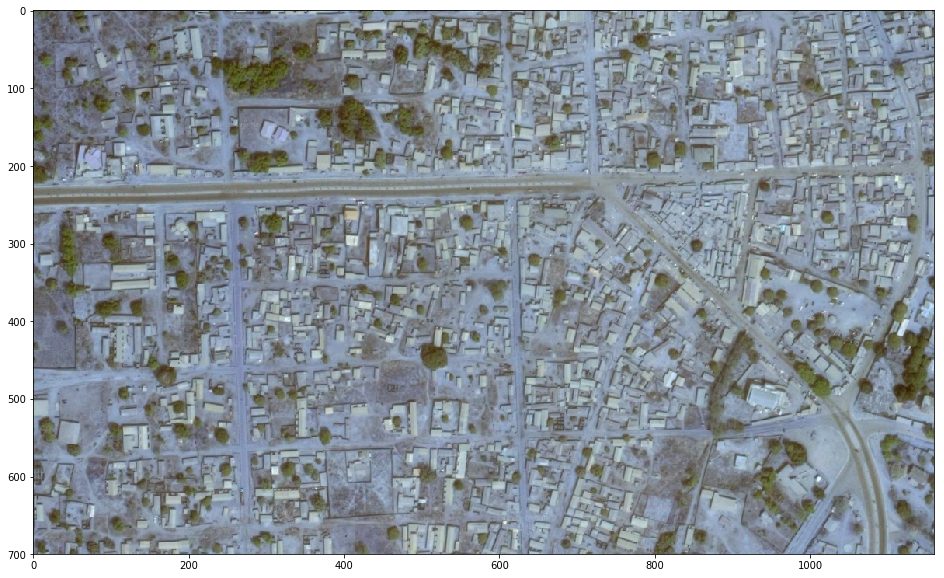

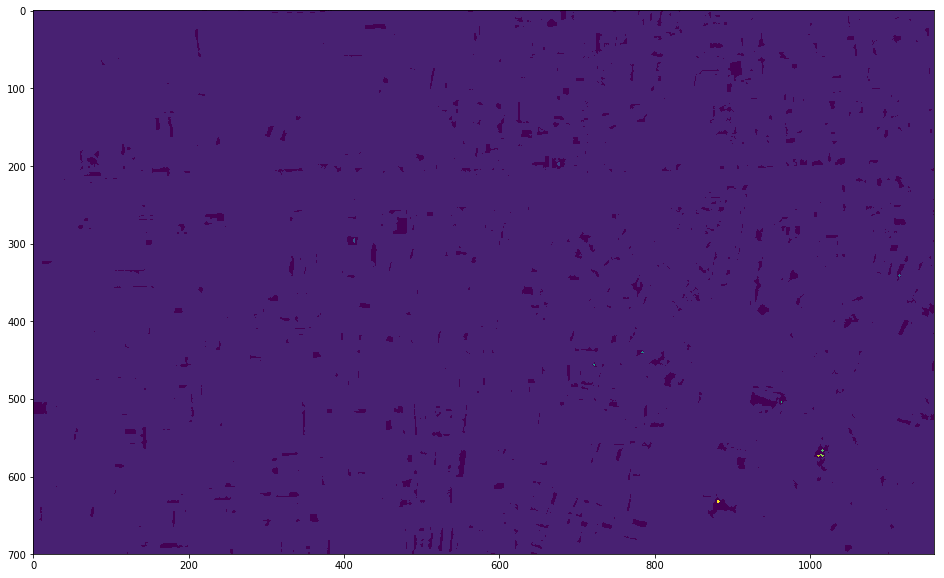

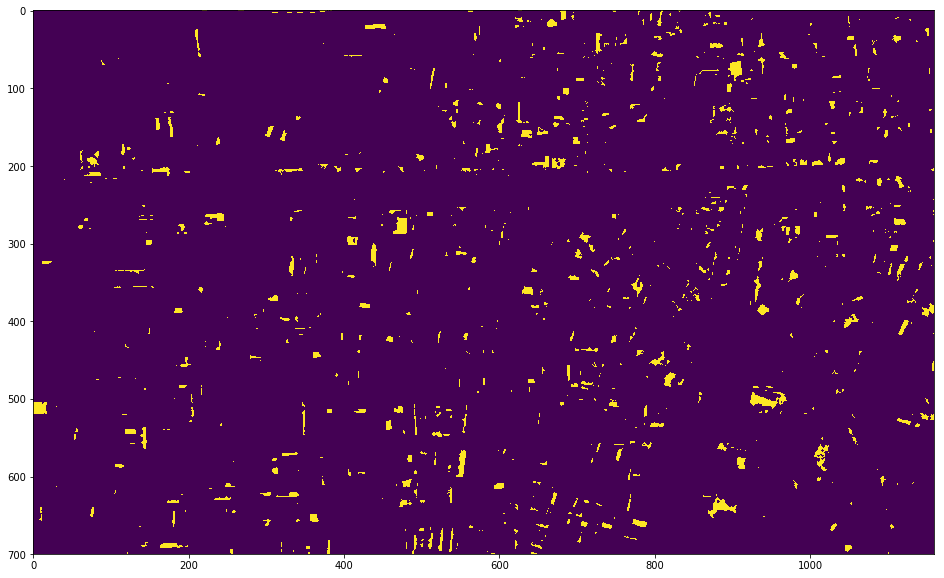

In [374]:
size_pixel_region=4
image =name+'_cropped.png'

im=read_image(image)
gr_image = read_image_gray(image)

s_image = segmentation_by_color(gr_image,180)
sigma=0.6
blobs = gaus_filter(s_image,sigma)
a = polarisation(blobs)

plt.figure(figsize=(20,10))
plt.imshow(im)


plt.figure(figsize=(20,10))
plt.imshow(blobs)

plt.figure(figsize=(20,10))
plt.imshow(a)


Computing image nº 0:  25%|██▌       | 1/4 [00:05<00:17,  5.70s/it]

Number of HOUSES FOUND:  305



Computing image nº 0:  50%|█████     | 2/4 [00:13<00:12,  6.22s/it]

Number of HOUSES FOUND:  338



Computing image nº 0:  75%|███████▌  | 3/4 [00:18<00:05,  5.88s/it]

Number of HOUSES FOUND:  296



Computing image nº 0: 100%|██████████| 4/4 [00:25<00:00,  6.37s/it]

Number of HOUSES FOUND:  232
Number of HOUSES FOUND WITH SIZE FILTER4 pixels:  601


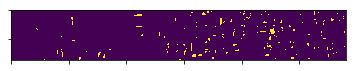

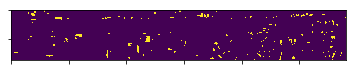

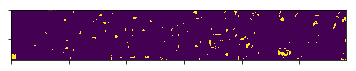

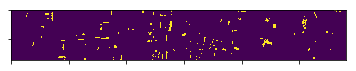

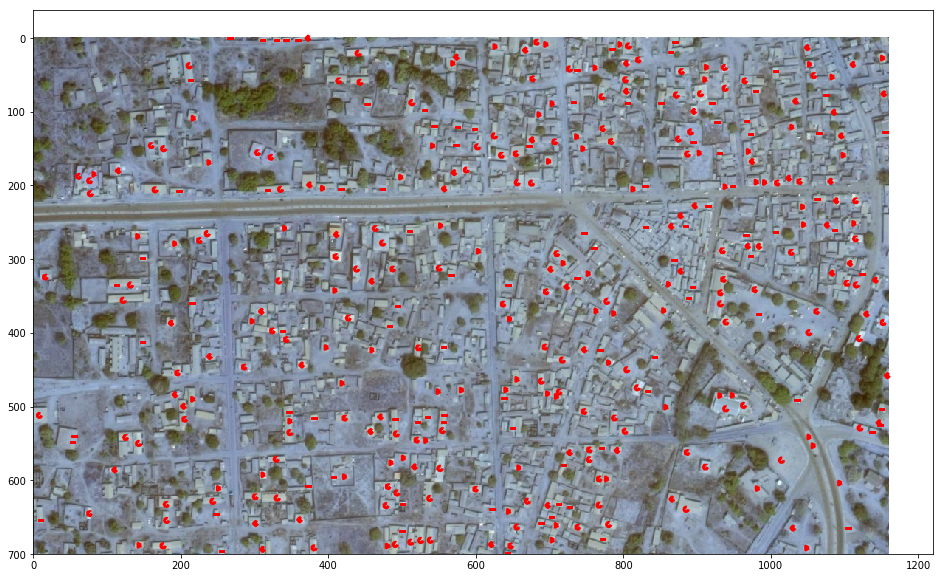

In [375]:
regs = []
begin = []
size_pixel_region=4
p_1=np.count_nonzero(a == 1)/(np.count_nonzero(a == 0)+np.count_nonzero(a == 1))
n=max(int(p_1*160),1)
z=0
for chop in tqdm.tqdm([a[int(i*len(a)/n):int((i+1)*len(a)/n)] for i in range(n)],
                          desc = 'Computing image nº %1d'% ( z )):
    
    reg = locate_regions(chop) 

    regs.append(reg)
    begin.append(z*len(a)/n)
    z+=1

    f, ax = plt.subplots()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(chop)

    print("Number of HOUSES FOUND: % 3d"%(len(reg)))

if len(regs)>0:
    coords=count_regions_and_plot_and_getcoord(regs,size_pixel_region,begin,im,center)


Number of HOUSES FOUND WITH SIZE FILTER4 pixels:  601


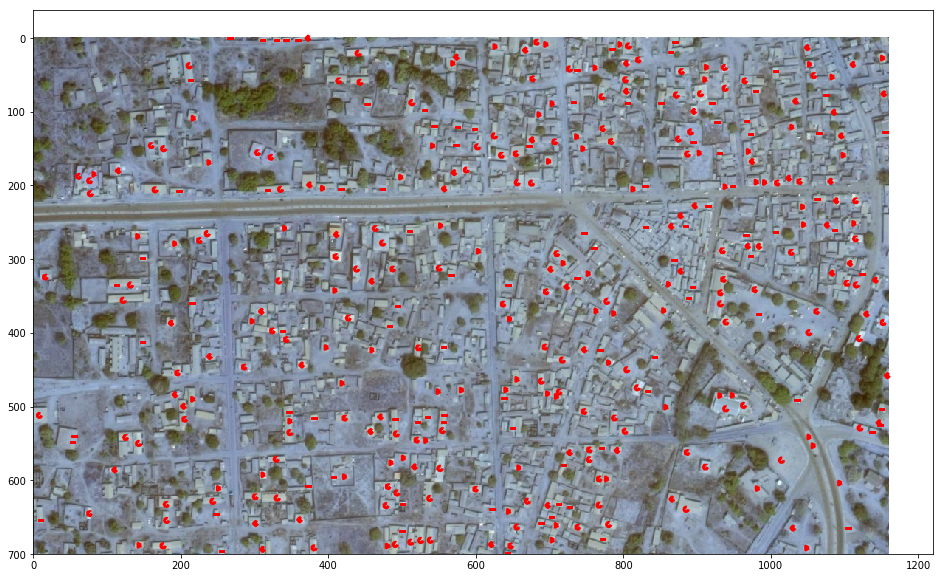

In [380]:
long_crop_center = long+abs(9.9597622-9.95976)
lat_crop_center= lat - abs(2.9468516-2.9467)
center=(long_crop_center, lat_crop_center)

coords=count_regions_and_plot_and_getcoord(regs,size_pixel_region,begin,im,center)

In [381]:
df_houses=pd.DataFrame(coords,columns=['latitude','longitude'])

# SAVE IN GSHEETs

## OPEN GOOGLE SHEETS

## AUTHENTIFICATION

In [298]:
SCOPES = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive',
         'https://www.googleapis.com/auth/drive.file',
         'https://www.googleapis.com/auth/spreadsheets.currentonly',
         'https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/presentations',
         'https://www.googleapis.com/auth/drive.scripts',
         'https://www.googleapis.com/auth/drive.appdata',
         'https://www.googleapis.com/auth/drive.metadata'
        ]
store = file.Storage('/Users/5danalfaro/OAN/credentials/storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('/Users/5danalfaro/OAN/credentials/client_id.json', SCOPES)
    creds = tools.run_flow(flow, store)
drive_service = discovery.build('drive', 'v3', http=creds.authorize(Http()))
sheet_service = discovery.build('sheets', 'v4', http=creds.authorize(Http()))

In [294]:
def uploadFile(filename,filepath,folder_id,filetype,fileapp):    
    file_metadata = { 'name': filename,
                      'parents': [folder_id],
                      'mimeType': fileapp,
                    }  
                                                  
                             

    media = MediaFileUpload(filepath,
                            mimetype=filetype)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    
    #permission = drive_service.permissions().get(
        #fileId=file.get('id'), permissionId="-").execute()
    
    #permission['role'] = "owner"
    
    #return drive_service.permissions().update(
        #fileId=file.get('id'), permissionId="-", body=permission, transferOwnership=True).execute()

In [382]:
nom='df_houses_'+name
df_houses.to_csv(nom+'.csv')

In [383]:
drive_id_folder='1260i6QGMSd9aUdGHz9uez0ru523vCfq7'
uploadFile(nom + ".csv",
           nom + ".csv",
           drive_id_folder,"text/csv",'application/vnd.google-apps.spreadsheet')
os.remove(nom+'.csv')

# UPLOAD TO MYMAPS

<a href="https://www.google.com/maps/d/edit?mid=1MtbdRCmYDSSSWThGlJ_ZYkJhvRczLeBl&ll=9.936057100985765%2C3.2051019633502165&z=17" target="_parent"><img src="https://lh4.googleusercontent.com/wFWTbQtnm83_tZYhu2w18mjQ8JGJ2OD_fE_dwFUHAQVm_O3tpQVnzB3vD_kwo0MXiapCG2SNQqRtx_uU4ydC-mBgRkiMfCPa_TZh79BOZMeY8Kh2zi4gYDRixc1SPmnNmQWuZDBN" alt="Open Maps"/></a>


## upload to firebase

In [354]:
#Convert info to dict and upload to firebase
houses = df_houses.to_dict('index')
houses_dict = [{k: v} for k, v in houses.items()] 
houses_l_dict = []
for i,house in enumerate(houses_dict):
    id_house=list(house.keys())[0]
    new_data={'coordinates':{
                    'longitude':house[id_house]['longitude'],
                    'latitude':house[id_house]['latitude']}
             }
    houses_l_dict.append(new_data)

    db.collection(u'houses').add(new_data)

# Distance to pompe

In [402]:
df_houses.loc[0,'latitude']

9.937709412698414

In [401]:
coord_pump[0]

3.20575

In [398]:
def distace_topump(x,coord_pump):
    x_dist = abs(coord_pump[0]-x['latitude'])*111111 
    y_dist = abs(coord_pump[1]-x['longitude'])*111111 
    distance = math.sqrt(x_dist**2+y_dist**2)
    
    return distance
    

In [403]:
coord_pump=(long,lat)
df_houses['distance']=df_houses.apply(lambda x: distace_topump(x,coord_pump),axis=1)

In [408]:
#4km/h speed walk, how many minutes in average people do to the source
df_houses['distance'].mean()*60/4000

4.407275937981471